### Importing all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sqlite3
from helper_functions import * #Hope and Adam's
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
#df = get_clean_df()
#df.info()

In [3]:
#df[['domestic_gross_movie_gross','clean_domestic_gross']]

___
# Reading in the Data

## movie_gross CSV

Domestic Gross and Foreign Gross are hard to read, because numbers are very large, we should consider adjusting the values
probably by making new columns as domestic_gross_mil and foreign_gross_mil

**Null Value Columns:**
* foreign_gross

In [4]:
movie_gross = pd.read_csv("../Data/bom.movie_gross.csv")
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [5]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


***
## Internet Movie Database (IMDB)
![alt text](https://raw.githubusercontent.com/learn-co-curriculum/dsc-ai-academy-semester1-capstone/main/movie_data_erd.jpeg "Logo Title Text 1")

In [6]:
#List of Tables for original table names to read the data in easily
conn = sqlite3.connect("../Data/im.db")
sql_query = """
SELECT name FROM sqlite_master  
WHERE type='table';
"""
pd.read_sql(sql_query,conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


## Persons table
**Null Value Columns:**
* death_year
* birth_year
* primary_profession

In [7]:
q = """
SELECT * FROM persons
"""
persons_df = pd.read_sql(q, conn)
persons_df.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [8]:
persons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


## Writers table

Many-to-many bridge table with no missing values

In [9]:
q = """
SELECT * FROM writers
"""
writers_df = pd.read_sql(q, conn)
writers_df

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087
...,...,...
255868,tt8999892,nm10122246
255869,tt8999974,nm10122357
255870,tt9001390,nm6711477
255871,tt9004986,nm4993825


In [10]:
writers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255873 entries, 0 to 255872
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   255873 non-null  object
 1   person_id  255873 non-null  object
dtypes: object(2)
memory usage: 3.9+ MB


## Directors table

Many-to-many bridge table with no missing values

In [11]:
q = """
SELECT * FROM directors
"""
directors_df = pd.read_sql(q, conn)
directors_df.head()

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


In [12]:
directors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


## known_for table

Many-to-many bridge table with no missing values

In [13]:
q = """
SELECT * FROM known_for
"""
known_for_df = pd.read_sql(q, conn)
known_for_df.head()

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241
2,nm0061671,tt0844471
3,nm0061671,tt0118553
4,nm0061865,tt0896534


In [14]:
known_for_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638260 entries, 0 to 1638259
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   person_id  1638260 non-null  object
 1   movie_id   1638260 non-null  object
dtypes: object(2)
memory usage: 25.0+ MB


## Principals table

**Null Value Columns:**
* job
* characters

Actors don't have non-null values under jobs

Some actors have null values under the character column

In [15]:
q = """
SELECT * FROM principals
"""
principals_df = pd.read_sql(q, conn)
principals_df.head()

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"


In [16]:
principals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   movie_id    1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   person_id   1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


In [17]:
principals_df[principals_df['category'] == 'actor'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256718 entries, 0 to 1028181
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   movie_id    256718 non-null  object
 1   ordering    256718 non-null  int64 
 2   person_id   256718 non-null  object
 3   category    256718 non-null  object
 4   job         0 non-null       object
 5   characters  204551 non-null  object
dtypes: int64(1), object(5)
memory usage: 13.7+ MB


## movie_basics table

**Null Value Columns:**
* runtime_minutes
* genres

In [18]:
q = """
SELECT * FROM movie_basics
"""
movie_basics_df = pd.read_sql(q, conn)
movie_basics_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [19]:
movie_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


## movie_ratings table
There are no null values, this table should easily join to other tables with movie_id, and the averagerating column seems like it would be a very useful component in measuring the success of a film

In [20]:
q = """
SELECT * FROM movie_ratings
"""
movie_ratings_df = pd.read_sql(q, conn)
movie_ratings_df.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [21]:
movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


## movie_akas

**Null Value Columns:**
* region
* language
* types
* attributes

The same movie ID is repeats for versions of movies in different regions, with is_original_title being used to identify which movie is the original.

In [22]:
q = """
SELECT * FROM movie_akas
"""
movie_akas_df = pd.read_sql(q, conn)
movie_akas_df.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [23]:
movie_akas_df.info()
#null values under region, language, types, and attributes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             278410 non-null  object 
 4   language           41715 non-null   object 
 5   types              168447 non-null  object 
 6   attributes         14925 non-null   object 
 7   is_original_title  331678 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 20.2+ MB


***
## rt_movie_info TSV
Contains an id column which relates to the other Rotten Tomatoe dataset (rt_reviews). This is the only dataframe with box_office earnings so it is useful for us to determine success of a movie in theatre, particularly by genre which is also information stored in this dataset.

**Null Value Columns:**
* synopsis
* rating
* genre 
* director
* writer
* theatre_date
* dvd_date
* currency
* box_office
* runtime
* studio  

In [24]:
rt_movie_info = pd.read_table("../Data/rt.movie_info.tsv", thousands=',')
rt_movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [25]:
rt_movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1560 non-null   int64  
 1   synopsis      1498 non-null   object 
 2   rating        1557 non-null   object 
 3   genre         1552 non-null   object 
 4   director      1361 non-null   object 
 5   writer        1111 non-null   object 
 6   theater_date  1201 non-null   object 
 7   dvd_date      1201 non-null   object 
 8   currency      340 non-null    object 
 9   box_office    340 non-null    float64
 10  runtime       1530 non-null   object 
 11  studio        494 non-null    object 
dtypes: float64(1), int64(1), object(10)
memory usage: 146.4+ KB


***
## rt_reviews TSV

Again this dataset has an id column which will relate it to the other Rotten Tomatoe dataframe (rt_movie_info)

Rating is given out of 5 stored as string, in order to use that iformation effectively we should have to convert that to a numeric value of sorts. It may also be interesting to just look at the reviews of the top critics only, with some research into what rotten tomatoes defines as a top critic. Regardless we should expect at the very least that top critics would have complete data entries with no null values so sorting for top critic review entries would probably solve a lot of other problems trying to pull information from this dataframe.

**Null Value Columns**
* review
* rating
* critic

In [26]:
rt_reviews = pd.read_table("../Data/rt.reviews.tsv", encoding = 'latin-1')
rt_reviews
#rating given out of 5 stored as string, might be best to just look at the numerator instead of storing as a fraction
#in a string
#again, id looks like it might connect to other tables hopefully

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [27]:
rt_reviews.loc[(rt_reviews['top_critic'] == 1)]

,id,review,rating,fresh,critic,top_critic,publisher,date
24,3,"The rapid dialogue is dry and mannered, like a...",2.5/4,rotten,Joe Williams,1,St. Louis Post-Dispatch,"September 6, 2012"
47,3,It feels like each and every moment bursts for...,2/4,rotten,Stephanie Merry,1,Washington Post,"August 24, 2012"
50,3,"There's not really a movie there, nothing that...",2/4,rotten,Mick LaSalle,1,San Francisco Chronicle,"August 23, 2012"
54,3,The film is all too faithful to its un-cinemat...,1.5/4,rotten,Colin Covert,1,Minneapolis Star Tribune,"August 23, 2012"
55,3,"Cosmopolis,"" because of its allegiance to the ...",2/4,rotten,Moira MacDonald,1,Seattle Times,"August 23, 2012"
...,...,...,...,...,...,...,...,...
54419,2000,"Sleek, shallow, but frequently amusing.",2.5/4,fresh,Gene Seymour,1,Newsday,"September 27, 2002"
54420,2000,The spaniel-eyed Jean Reno infuses Hubert with...,3/4,fresh,Megan Turner,1,New York Post,"September 27, 2002"
54424,2000,Dawdles and drags when it should pop; it doesn...,1.5/5,rotten,Manohla Dargis,1,Los Angeles Times,"September 26, 2002"
54426,2000,The film lapses too often into sugary sentimen...,NaN,rotten,Paul Malcolm,1,L.A. Weekly,"September 26, 2002"


In [28]:
rt_reviews.info()
#null values: review, rating, critic

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


___
## tmdb movies CSV
TMDB uses a list of genre id's, we need to translate the id's to something comprehendible. Popularity is also a seemingly vague value that a dataframe dictionary would be helpful for. (Note we'll also need to add data dictionaries folder to our repo)

**No Null Value Columns**

In [29]:
movies = pd.read_csv("../Data/tmdb.movies.csv")
movies.head()
# Need something to translate the genre ids 

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [30]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


___
## TN movie_budgets CSV

**No Null Value Columns**

In [31]:
movie_budgets = pd.read_csv("../Data/tn.movie_budgets.csv")
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [32]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


___

## Taking a look at box office numbers by genre

**For reference: Heres a basic look at the rt_movie_info dataframe**

In [33]:
rt_movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [34]:
rt_movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1560 non-null   int64  
 1   synopsis      1498 non-null   object 
 2   rating        1557 non-null   object 
 3   genre         1552 non-null   object 
 4   director      1361 non-null   object 
 5   writer        1111 non-null   object 
 6   theater_date  1201 non-null   object 
 7   dvd_date      1201 non-null   object 
 8   currency      340 non-null    object 
 9   box_office    340 non-null    float64
 10  runtime       1530 non-null   object 
 11  studio        494 non-null    object 
dtypes: float64(1), int64(1), object(10)
memory usage: 146.4+ KB


**First we need to make the genre column into a list of strings instead of one big string**

In [35]:
genres = rt_movie_info['genre']
rt_movie_info['genre'] = genres.str.split(pat="|") #Original string sepates values with | and no spaces
rt_movie_info['genre']

0                 [Action and Adventure, Classics, Drama]
1                    [Drama, Science Fiction and Fantasy]
2                    [Drama, Musical and Performing Arts]
3                           [Drama, Mystery and Suspense]
4                                        [Drama, Romance]
                              ...                        
1555    [Action and Adventure, Horror, Mystery and Sus...
1556                [Comedy, Science Fiction and Fantasy]
1557    [Classics, Comedy, Drama, Musical and Performi...
1558    [Comedy, Drama, Kids and Family, Sports and Fi...
1559    [Action and Adventure, Art House and Internati...
Name: genre, Length: 1560, dtype: object

In [36]:
#rt_movie_info3 = rt_movie_info.explode("genre").reset_index(drop=True)
#rt_movie_info3['release_year'] = rt_movie_info3['theater_date'].dt.year

**Now we pull out each genre and make a new table where:**
* Each row is an individual movie
* Each genre is a column with binary variables
    * 1 = Genre is Present
    * 0 = Genre is not Present

In [37]:
rt_movie_genres = pd.get_dummies(rt_movie_info['genre'].apply(pd.Series).stack()).sum(level=0)
rt_movie_genres

,Action and Adventure,Animation,Anime and Manga,Art House and International,Classics,Comedy,Cult Movies,Documentary,Drama,Faith and Spirituality,...,Horror,Kids and Family,Musical and Performing Arts,Mystery and Suspense,Romance,Science Fiction and Fantasy,Special Interest,Sports and Fitness,Television,Western
0,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1556,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1557,0,0,0,0,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1558,0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0


In [38]:
rt_movie_genres.info()
#Just checking that that there are no null values or nan columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552 entries, 0 to 1559
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Action and Adventure         1552 non-null   uint8
 1   Animation                    1552 non-null   uint8
 2   Anime and Manga              1552 non-null   uint8
 3   Art House and International  1552 non-null   uint8
 4   Classics                     1552 non-null   uint8
 5   Comedy                       1552 non-null   uint8
 6   Cult Movies                  1552 non-null   uint8
 7   Documentary                  1552 non-null   uint8
 8   Drama                        1552 non-null   uint8
 9   Faith and Spirituality       1552 non-null   uint8
 10  Gay and Lesbian              1552 non-null   uint8
 11  Horror                       1552 non-null   uint8
 12  Kids and Family              1552 non-null   uint8
 13  Musical and Performing Arts  1552 non-null   uin

**Now we can join back the new rt_movies_genres table back to the original**

In this case we only want to look at box office, theater_date, and dvd_date to get a good idea of what genres are doing well while they're in theatre

In [39]:
rt_movie_info2 = pd.concat([rt_movie_info[['box_office']], rt_movie_genres], axis = 1)
rt_movie_info2 = pd.concat([rt_movie_info[['theater_date']], rt_movie_info2], axis = 1)
rt_movie_info2 = pd.concat([rt_movie_info[['dvd_date']], rt_movie_info2], axis = 1)

From this data we can also calculate the number of days in theater which we can store as a float to do calculations with

In [40]:
rt_movie_info2['theater_date'] = pd.to_datetime(rt_movie_info2['theater_date'])
rt_movie_info2['dvd_date'] = pd.to_datetime(rt_movie_info2['dvd_date'])
rt_movie_info2['days_in_theater'] = rt_movie_info2['dvd_date'] - rt_movie_info2['theater_date']
rt_movie_info2['days_in_theater'] = rt_movie_info2['days_in_theater'].dt.days #dt.dats converts timedelta to float

In [41]:
rt_movie_info2.head()

,dvd_date,theater_date,box_office,Action and Adventure,Animation,Anime and Manga,Art House and International,Classics,Comedy,Cult Movies,...,Kids and Family,Musical and Performing Arts,Mystery and Suspense,Romance,Science Fiction and Fantasy,Special Interest,Sports and Fitness,Television,Western,days_in_theater
0,2001-09-25,1971-10-09,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10944.0
1,2013-01-01,2012-08-17,600000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,137.0
2,2000-04-18,1996-09-13,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1313.0
3,1997-08-27,1994-12-09,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,992.0
4,NaT,NaT,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN


**Let's create 2 more columns calculating box office earnings/day and box office earnings/week so we have a more reliable way to compare box office earnings between movies that were in theatres for different lengths of time**

In [42]:
rt_movie_info2['box_office_perday'] = rt_movie_info2['box_office'] / rt_movie_info2['days_in_theater']
rt_movie_info2['box_office_perweek'] = rt_movie_info2['box_office'] / (rt_movie_info2['days_in_theater'] / 7)
rt_movie_info2['release_year'] = rt_movie_info2['theater_date'].dt.year

In [43]:
#CHANGE BETWEEN PERDAY AND PERWEEK HERE TO GET DIFFERENT OUTPUT 
#YOU WOULD ALSO NEED TO CHANGE GRAPH TITLES AND AXXES LABELS
#PER DAY LOOKS NICER AND DOESN'T MAP THE Y AXIS WITH SCIENTIFIC NOTATION SO THAT'S WHAT I LEAVE AS DEFAULT
rt_movie_info2 = rt_movie_info2.mask(rt_movie_info2 == 1, rt_movie_info2['box_office_perday'], axis = 0)
rt_movie_info2 = rt_movie_info2.fillna(0)
rt_movie_info2

,dvd_date,theater_date,box_office,Action and Adventure,Animation,Anime and Manga,Art House and International,Classics,Comedy,Cult Movies,...,Romance,Science Fiction and Fantasy,Special Interest,Sports and Fitness,Television,Western,days_in_theater,box_office_perday,box_office_perweek,release_year
0,2001-09-25 00:00:00,1971-10-09 00:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,10944.0,0.000000,0.000000e+00,1971.0
1,2013-01-01 00:00:00,2012-08-17 00:00:00,600000.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4379.562044,0.0,0.0,0.0,0.0,137.0,4379.562044,3.065693e+04,2012.0
2,2000-04-18 00:00:00,1996-09-13 00:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,1313.0,0.000000,0.000000e+00,1996.0
3,1997-08-27 00:00:00,1994-12-09 00:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,992.0,0.000000,0.000000e+00,1994.0
4,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,2007-01-02 00:00:00,2006-08-18 00:00:00,33886034.0,247343.313869,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,137.0,247343.313869,1.731403e+06,2006.0
1556,2001-04-17 00:00:00,1993-07-23 00:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,2825.0,0.000000,0.000000e+00,1993.0
1557,2004-05-11 00:00:00,1962-01-01 00:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,15471.0,0.000000,0.000000e+00,1962.0
1558,2002-01-29 00:00:00,1993-04-01 00:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,3225.0,0.000000,0.000000e+00,1993.0


**Now we'll create a list of all the different genres to reference when sorting thedata**

In [44]:
genres = rt_movie_info2.columns[3:-4] #Use [3:-4] to ignore non-genre columns
genres

Index(['Action and Adventure', 'Animation', 'Anime and Manga',
       'Art House and International', 'Classics', 'Comedy', 'Cult Movies',
       'Documentary', 'Drama', 'Faith and Spirituality', 'Gay and Lesbian',
       'Horror', 'Kids and Family', 'Musical and Performing Arts',
       'Mystery and Suspense', 'Romance', 'Science Fiction and Fantasy',
       'Special Interest', 'Sports and Fitness', 'Television', 'Western'],
      dtype='object')

**With that list of genres we can create a dictionary of genres following -- {genre:mean earnings per day}**

In [45]:
genre_dict = {}
for genre in genres: 
    if pd.isna(rt_movie_info2.loc[rt_movie_info2[genre] != 0][genre].mean()) == False:
        genre_dict[genre] = rt_movie_info2.loc[rt_movie_info2[genre] != 0][genre].mean()
genre_dict

{'Action and Adventure': 463707.45811494876,
 'Animation': 480634.86549955094,
 'Art House and International': 16827.997836361374,
 'Classics': 47030.47263681592,
 'Comedy': 327009.89400855266,
 'Cult Movies': 127522.93577981651,
 'Documentary': 93519.41294421114,
 'Drama': 211589.22692834298,
 'Faith and Spirituality': 42219.559376888734,
 'Horror': 216519.98261260497,
 'Kids and Family': 458587.33773976687,
 'Musical and Performing Arts': 110923.39535708177,
 'Mystery and Suspense': 311920.4885587816,
 'Romance': 363060.69644747954,
 'Science Fiction and Fantasy': 552613.7274257825,
 'Special Interest': 18253.176429931256,
 'Sports and Fitness': 147158.02625143842,
 'Television': 101253.17405900195,
 'Western': 72291.223837645}

**Now we'll graph the findings**

[Text(0, 0, 'Action and Adventure'),
 Text(1, 0, 'Animation'),
 Text(2, 0, 'Art House and International'),
 Text(3, 0, 'Classics'),
 Text(4, 0, 'Comedy'),
 Text(5, 0, 'Cult Movies'),
 Text(6, 0, 'Documentary'),
 Text(7, 0, 'Drama'),
 Text(8, 0, 'Faith and Spirituality'),
 Text(9, 0, 'Horror'),
 Text(10, 0, 'Kids and Family'),
 Text(11, 0, 'Musical and Performing Arts'),
 Text(12, 0, 'Mystery and Suspense'),
 Text(13, 0, 'Romance'),
 Text(14, 0, 'Science Fiction and Fantasy'),
 Text(15, 0, 'Special Interest'),
 Text(16, 0, 'Sports and Fitness'),
 Text(17, 0, 'Television'),
 Text(18, 0, 'Western')]

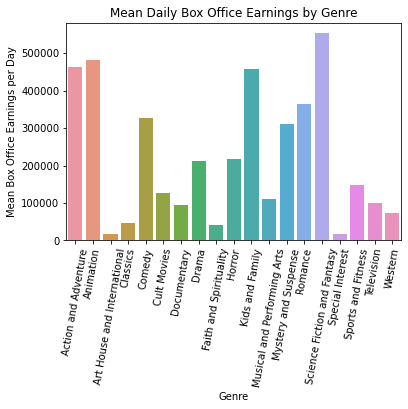

In [46]:
fig, ax = plt.subplots()
keys = list(genre_dict.keys())
# get values in the same order as keys, and parse percentage values
vals = list(genre_dict.values())
sns.barplot(x=keys, y=vals).set(title='Mean Daily Box Office Earnings by Genre')
ax.set_xlabel('Genre')
ax.set_ylabel("Mean Box Office Earnings per Day")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 80)

**We'll narrow our search to only movies released in theatre 2010 or later**

Then we repeat steps to remake the dictionary and graph again

In [47]:
today = pd.to_datetime('today').normalize()
rt_movie_info_last_decade = rt_movie_info2.where(today.year - rt_movie_info2['release_year'] <= 20)

In [48]:
genre_dict = {}
for genre in genres: 
    if pd.isna(rt_movie_info_last_decade.loc[rt_movie_info_last_decade[genre] != 0][genre].mean()) == False:
        genre_dict[genre] = rt_movie_info_last_decade.loc[rt_movie_info_last_decade[genre] != 0][genre].mean()
genre_dict

{'Action and Adventure': 497175.3675704538,
 'Animation': 495856.3400550537,
 'Art House and International': 18136.16509555623,
 'Classics': 47030.47263681592,
 'Comedy': 336704.43230283086,
 'Cult Movies': 127522.93577981651,
 'Documentary': 93519.41294421116,
 'Drama': 217675.0772202346,
 'Faith and Spirituality': 42219.559376888734,
 'Horror': 227255.51902232177,
 'Kids and Family': 495906.6104279869,
 'Musical and Performing Arts': 131054.4818456443,
 'Mystery and Suspense': 337517.4522822498,
 'Romance': 379952.8459916016,
 'Science Fiction and Fantasy': 607902.6955613409,
 'Special Interest': 18253.176429931256,
 'Sports and Fitness': 147158.02625143842,
 'Television': 101253.17405900195,
 'Western': 85487.83075603851}

[Text(0, 0, 'Action and Adventure'),
 Text(1, 0, 'Animation'),
 Text(2, 0, 'Art House and International'),
 Text(3, 0, 'Classics'),
 Text(4, 0, 'Comedy'),
 Text(5, 0, 'Cult Movies'),
 Text(6, 0, 'Documentary'),
 Text(7, 0, 'Drama'),
 Text(8, 0, 'Faith and Spirituality'),
 Text(9, 0, 'Horror'),
 Text(10, 0, 'Kids and Family'),
 Text(11, 0, 'Musical and Performing Arts'),
 Text(12, 0, 'Mystery and Suspense'),
 Text(13, 0, 'Romance'),
 Text(14, 0, 'Science Fiction and Fantasy'),
 Text(15, 0, 'Special Interest'),
 Text(16, 0, 'Sports and Fitness'),
 Text(17, 0, 'Television'),
 Text(18, 0, 'Western')]

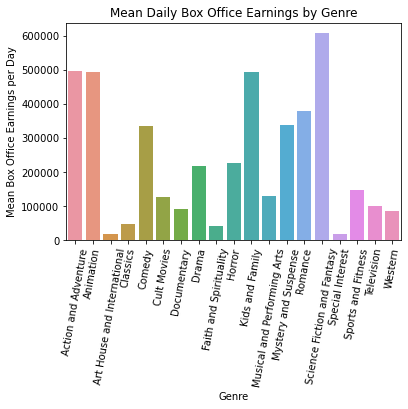

In [49]:
fig, ax = plt.subplots()
keys = list(genre_dict.keys())
# get values in the same order as keys, and parse percentage values
vals = list(genre_dict.values())
sns.barplot(x=keys, y=vals).set(title='Mean Daily Box Office Earnings by Genre')
ax.set_xlabel('Genre')
ax.set_ylabel("Mean Box Office Earnings per Day")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 80)

In [50]:
rt_movie_info_last_decade = rt_movie_info_last_decade[~rt_movie_info_last_decade['release_year'].isna()]

In [51]:
def normalize_column(values):
    mi = np.min(values) 
    ma = np.max(values) 
    norm = (values - mi)/(ma-mi) 
    return(pd.DataFrame(norm))

In [52]:
rt_movie_info_last_decade

,dvd_date,theater_date,box_office,Action and Adventure,Animation,Anime and Manga,Art House and International,Classics,Comedy,Cult Movies,...,Romance,Science Fiction and Fantasy,Special Interest,Sports and Fitness,Television,Western,days_in_theater,box_office_perday,box_office_perweek,release_year
1,2013-01-01 00:00:00,2012-08-17 00:00:00,600000.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,4379.562044,0.0,0.0,0.0,0.0,137.0,4379.562044,3.065693e+04,2012.0
6,2002-06-18 00:00:00,2002-01-11 00:00:00,41032915.0,0.000000,0.0,0.0,0.00000,0.0,259701.993671,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,158.0,259701.993671,1.817914e+06,2002.0
7,2007-10-02 00:00:00,2006-04-27 00:00:00,224114.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,523.0,428.516252,2.999614e+03,2006.0
8,2010-11-09 00:00:00,2010-06-30 00:00:00,134904.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,132.0,1022.000000,7.154000e+03,2010.0
12,2003-09-30 00:00:00,2002-08-23 00:00:00,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,403.0,0.000000,0.000000e+00,2002.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,2005-12-20 00:00:00,2005-09-30 00:00:00,25335935.0,312789.320988,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,312789.320988,0.0,0.0,0.0,0.0,81.0,312789.320988,2.189525e+06,2005.0
1542,2012-11-20 00:00:00,2012-10-05 00:00:00,1416189.0,0.000000,0.0,0.0,0.00000,0.0,30786.717391,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,46.0,30786.717391,2.155070e+05,2012.0
1545,2007-10-09 00:00:00,2007-06-01 00:00:00,59371.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,130.0,456.700000,3.196900e+03,2007.0
1546,2003-10-07 00:00:00,2002-08-30 00:00:00,794306.0,0.000000,0.0,0.0,1970.98263,0.0,1970.982630,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,403.0,1970.982630,1.379688e+04,2002.0


In [53]:
AandA = rt_movie_info_last_decade[rt_movie_info_last_decade['Action and Adventure'] != 0]['Action and Adventure'].to_list()
stats.normaltest(AandA)
AandA

[211528.0824742268,
 327878.7878787879,
 112703.01052631579,
 330230.54615384614,
 715914.4607843137,
 473999.8534482759,
 195579.7614678899,
 11100.53409090909,
 487692.3076923077,
 40753.88372093023,
 387101.46788990824,
 547472.0151515151,
 549773.7556561086,
 1023085.8476821192,
 395128.4379562044,
 262820.45263157896,
 381972.61788617884,
 141584.86754966888,
 90517.24137931035,
 927264.8699186991,
 275115.24615384615,
 663050.5588235294,
 139391.89928057554,
 1009623.2450980392,
 216189.4568965517,
 2397.2602739726026,
 1603711.4520547944,
 127522.93577981651,
 728474.6178861789,
 257167.43119266056,
 255555.55555555556,
 4477.611940298508,
 3189486.6210526316,
 773.3973509933775,
 37072.00862068965,
 31707.317073170732,
 1328371.644329897,
 176154.6551724138,
 699229.0948275862,
 830212.2613636364,
 135750.44444444444,
 2453278.6885245903,
 1095549.698275862,
 431707.31707317074,
 427706.4210526316,
 1037744.7101449275,
 926227.3082706766,
 282443.2837837838,
 94207.25862068965,

<AxesSubplot:ylabel='Density'>

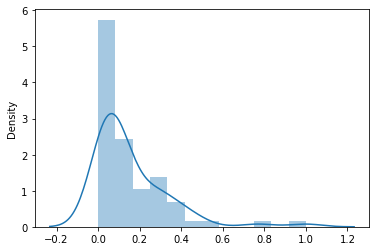

In [54]:
normal_AandA = normalize_column(AandA)
sns.distplot(normal_AandA)

In [55]:
stats.normaltest(normal_AandA)

NormaltestResult(statistic=array([51.24415411]), pvalue=array([7.45544069e-12]))

## Finding how long different genres are in theater for

In [56]:
rt_movie_info = pd.read_table("../Data/rt.movie_info.tsv", thousands=',')
rt_movie_info3 = rt_movie_info

In [57]:
rt_movie_info3['theater_date'] = pd.to_datetime(rt_movie_info3['theater_date'])
rt_movie_info3['dvd_date'] = pd.to_datetime(rt_movie_info3['dvd_date'])
rt_movie_info3['days_in_theater'] = rt_movie_info3['dvd_date'] - rt_movie_info3['theater_date']
rt_movie_info3['days_in_theater'] = rt_movie_info3['days_in_theater'].dt.days #dt.dats converts timedelta to float
rt_movie_info3['release_year'] = rt_movie_info3['theater_date'].dt.year
today = pd.to_datetime('today').normalize()
rt_movie_info3 = rt_movie_info3[(today.year - rt_movie_info3['release_year'] <= 100)]
rt_movie_info3

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,days_in_theater,release_year
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09,2001-09-25,NaN,NaN,104 minutes,NaN,10944.0,1971.0
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,$,600000.0,108 minutes,Entertainment One,137.0,2012.0
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,1996-09-13,2000-04-18,NaN,NaN,116 minutes,NaN,1313.0,1996.0
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09,1997-08-27,NaN,NaN,128 minutes,NaN,992.0,1994.0
5,8,The year is 1942. As the Allies unite overseas...,PG,Drama|Kids and Family,Jay Russell,Gail Gilchriest,2000-03-03,2000-07-11,NaN,NaN,95 minutes,Warner Bros. Pictures,130.0,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,2006-08-18,2007-01-02,$,33886034.0,106 minutes,New Line Cinema,137.0,2006.0
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,1993-07-23,2001-04-17,NaN,NaN,88 minutes,Paramount Vantage,2825.0,1993.0
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,1962-01-01,2004-05-11,NaN,NaN,111 minutes,NaN,15471.0,1962.0
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,1993-04-01,2002-01-29,NaN,NaN,101 minutes,NaN,3225.0,1993.0


In [58]:
genres = rt_movie_info3['genre']
rt_movie_info3['genre'] = genres.str.split(pat="|")
rt_movie_info3 = rt_movie_info3.explode("genre").reset_index(drop=True)
rt_movie_info3

<ipython-input-58-bc1d5cda3415>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_movie_info3['genre'] = genres.str.split(pat="|")


,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,days_in_theater,release_year
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure,William Friedkin,Ernest Tidyman,1971-10-09,2001-09-25,NaN,NaN,104 minutes,NaN,10944.0,1971.0
1,1,"This gritty, fast-paced, and innovative police...",R,Classics,William Friedkin,Ernest Tidyman,1971-10-09,2001-09-25,NaN,NaN,104 minutes,NaN,10944.0,1971.0
2,1,"This gritty, fast-paced, and innovative police...",R,Drama,William Friedkin,Ernest Tidyman,1971-10-09,2001-09-25,NaN,NaN,104 minutes,NaN,10944.0,1971.0
3,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,$,600000.0,108 minutes,Entertainment One,137.0,2012.0
4,3,"New York City, not-too-distant-future: Eric Pa...",R,Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,$,600000.0,108 minutes,Entertainment One,137.0,2012.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,2000,"Suspended from the force, Paris cop Hubert is ...",R,Action and Adventure,NaN,Luc Besson,2001-09-27,2003-02-11,NaN,NaN,94 minutes,Columbia Pictures,502.0,2001.0
2865,2000,"Suspended from the force, Paris cop Hubert is ...",R,Art House and International,NaN,Luc Besson,2001-09-27,2003-02-11,NaN,NaN,94 minutes,Columbia Pictures,502.0,2001.0
2866,2000,"Suspended from the force, Paris cop Hubert is ...",R,Comedy,NaN,Luc Besson,2001-09-27,2003-02-11,NaN,NaN,94 minutes,Columbia Pictures,502.0,2001.0
2867,2000,"Suspended from the force, Paris cop Hubert is ...",R,Drama,NaN,Luc Besson,2001-09-27,2003-02-11,NaN,NaN,94 minutes,Columbia Pictures,502.0,2001.0


In [59]:
rt_movie_info4 = rt_movie_info3.dropna(subset=['dvd_date'])

In [60]:
genre_in_theater = rt_movie_info4.groupby("genre").median()[["days_in_theater"]].sort_values("days_in_theater", ascending=False)
#genre_in_theater[genre_in_theater['genre'] == 'Horror']
genre_in_theater


,days_in_theater
genre,
Classics,17026.5
Western,11406.0
Cult Movies,5297.0
Musical and Performing Arts,5254.0
Gay and Lesbian,3488.5
Art House and International,2699.0
Romance,2398.0
Science Fiction and Fantasy,2323.0
Horror,2319.0


In [61]:
rt_movie_info3[rt_movie_info3['genre'] == 'Science Fiction and Fantasy']

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,days_in_theater,release_year
4,3,"New York City, not-too-distant-future: Eric Pa...",R,Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,$,600000.0,108 minutes,Entertainment One,137.0,2012.0
16,15,When a diamond expedition in the Congo is lost...,PG-13,Science Fiction and Fantasy,Frank Marshall,John Patrick Shanley,1995-06-09,1999-07-27,NaN,NaN,108 minutes,NaN,1509.0,1995.0
32,25,"From ancient Japan's most enduring tale, the e...",PG-13,Science Fiction and Fantasy,Carl Erik Rinsch,Chris Morgan|Hossein Amini,2013-12-25,2014-04-01,$,20518224.0,127 minutes,Universal Pictures,97.0,2013.0
43,29,This futuristic adventure stars Lee Majors as ...,PG,Science Fiction and Fantasy,Martyn Burke,NaN,1981-04-01,2011-05-10,NaN,NaN,101 minutes,NaN,10996.0,1981.0
103,82,Donnie (Jake Gyllenhaal) is a bright and charm...,R,Science Fiction and Fantasy,Richard Kelly,Richard Kelly,2001-01-19,2002-03-19,NaN,NaN,113 minutes,Newmarket Film Group,424.0,2001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,1944,"In the 3D action-comedy The Green Hornet, Brit...",PG-13,Science Fiction and Fantasy,Michel Gondry,Evan Goldberg|Seth Rogen,2011-01-14,2011-05-03,$,98000000.0,119 minutes,Sony Pictures,109.0,2011.0
2815,1972,Stephen Somers wrote and directed this,R,Science Fiction and Fantasy,Stephen Sommers,Stephen Sommers,1998-01-30,1998-10-13,NaN,NaN,106 minutes,NaN,256.0,1998.0
2819,1973,Agency tackles the question of the efficiency ...,R,Science Fiction and Fantasy,George Kaczender,Noel Hynd|Paul Gottlieb,2004-01-01,2005-08-02,NaN,NaN,94 minutes,NaN,579.0,2004.0
2831,1980,A band of renegades on the run in outer space ...,PG-13,Science Fiction and Fantasy,Joss Whedon,Joss Whedon,2005-09-30,2005-12-20,$,25335935.0,119 minutes,Universal Pictures,81.0,2005.0


### We'll put this all in a function that can be called to return the median number of days a specific genre has been in theaters

In [62]:
def median_days_in_theater(genre):
    rt_movie_info = pd.read_table("../Data/rt.movie_info.tsv", thousands=',')
    rt_movie_info3 = rt_movie_info
    
    rt_movie_info3['theater_date'] = pd.to_datetime(rt_movie_info3['theater_date'])
    rt_movie_info3['dvd_date'] = pd.to_datetime(rt_movie_info3['dvd_date'])
    rt_movie_info3['days_in_theater'] = rt_movie_info3['dvd_date'] - rt_movie_info3['theater_date']
    rt_movie_info3['days_in_theater'] = rt_movie_info3['days_in_theater'].dt.days #dt.dats converts timedelta to float
    rt_movie_info3['release_year'] = rt_movie_info3['theater_date'].dt.year
    today = pd.to_datetime('today').normalize()
    rt_movie_info3 = rt_movie_info3[(today.year - rt_movie_info3['release_year'] <= 10)]
    
    genres = rt_movie_info3['genre']
    rt_movie_info3['genre'] = genres.str.split(pat="|")
    rt_movie_info3 = rt_movie_info3.explode("genre").reset_index(drop=True)
    
    genre_in_theatre = rt_movie_info4.groupby("genre").median()[["days_in_theater"]].sort_values("days_in_theater", ascending=False)
    
    median_days = genre_in_theater.loc[[genre]]['days_in_theater']
    median_days = median_days[0]
    
    return median_days

### And for a list of genre's for the function above. here's another function you can call

In [63]:
def genre_list():
    rt_movie_info = pd.read_table("../Data/rt.movie_info.tsv", thousands=',')
    rt_movie_info3 = rt_movie_info

    genres = rt_movie_info3['genre']
    rt_movie_info3['genre'] = genres.str.split(pat="|")
    rt_movie_info3 = rt_movie_info3.explode("genre").reset_index(drop=True)
    genres = rt_movie_info3['genre']
    
    return genres.unique()

In [64]:
genre_list()

array(['Action and Adventure', 'Classics', 'Drama',
       'Science Fiction and Fantasy', 'Musical and Performing Arts',
       'Mystery and Suspense', 'Romance', 'Kids and Family', 'Comedy',
       nan, 'Documentary', 'Special Interest',
       'Art House and International', 'Horror', 'Western', 'Television',
       'Sports and Fitness', 'Animation', 'Faith and Spirituality',
       'Cult Movies', 'Anime and Manga', 'Gay and Lesbian'], dtype=object)

In [65]:
median_days_in_theater('Action and Adventure')

<ipython-input-62-7165fffb2f3f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_movie_info3['genre'] = genres.str.split(pat="|")


1501.0

In [66]:
AaA = median_days_in_theater('Action and Adventure')

<ipython-input-62-7165fffb2f3f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_movie_info3['genre'] = genres.str.split(pat="|")


***

***
# Looking into Actors, Writers, and Producer Recomendations

For the genre recomendations our group makes, we'd like to give insights into the most experienced and succesful professionals available for the different projects.

**Below is an exploration of the top 10 most experienced actors, writers, and producers in terms of the metrics that we have based our recomendations on:**
   
* Popularity
* Domestic gross
* Profit

## Actors, Writers, and Producers -- POPULARITY
For the purpose of seeing how different actors, writers, and producers perform in terms of popularity. All the information we'll need is alread stored in the IMDB database. 

**We'll be sorting through to only include movies that:**
* fit our genre of choice
* are US productions
* have at least 100 votes for the movie's rating

Then with that criteria in place we'll find the top 10 Actors, Writers, and Producers in terms of number of projects they've been principal contributors to and plot their movies success in terms of average rating.

## Producers

**Data Querying**

We filter through the dataset to include only producers who:
* Have worked in US film productions with at least 100 ratings in the database
* Were principal contributers to their projects
* Are still alive

In [99]:
#List of Tables for original table names to read the data in easily

conn = sqlite3.connect("../Data/im.db")
sql_query = """
SELECT name FROM sqlite_master  
WHERE type='table';
"""
pd.read_sql(sql_query,conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [100]:
#principals table includes only the top 10 principal contributors to a project, so that's how we'll filter out
#non-influencial contributions to projects

#decision to order by averagerating is arbitrary

q= """
SELECT 
    pr.person_id,
    p.primary_name,
    pr.job,
    pr.movie_id,
    mb.primary_title,
    mb.genres,
    mr.averagerating
FROM principals AS pr
INNER JOIN persons AS p
    USING(person_id)
INNER JOIN movie_basics AS mb
    USING(movie_id)
INNER JOIN movie_ratings AS mr
    USING(movie_id)
INNER JOIN movie_akas AS ma
    USING(movie_id)
WHERE 
    p.death_year IS NULL
    AND ma.region = 'US'
    AND mr.numvotes >= 100
    AND pr.job = 'producer'
ORDER BY mr.averagerating DESC
"""
producers = pd.read_sql(q, conn)

#drop any duplicate rows
producers = producers.drop_duplicates()

producers.head()

,person_id,primary_name,job,movie_id,primary_title,genres,averagerating
0,nm0382268,David Heyman,producer,tt7131622,Once Upon a Time ... in Hollywood,"Comedy,Drama",9.7
2,nm0570690,Shannon McIntosh,producer,tt7131622,Once Upon a Time ... in Hollywood,"Comedy,Drama",9.7
4,nm5417181,Matt Schrader,producer,tt8354112,Mosul,Documentary,9.5
6,nm8961213,Jessica Heinrich,producer,tt6842524,"Hare Krishna! The Mantra, the Movement and the...",Documentary,9.5
7,nm1179078,Brett Rapkin,producer,tt6859280,"The Nagano Tapes: Rewound, Replayed & Reviewed",Documentary,9.4


In [101]:
#Seeing genres are stored as strings we'll transform that column into lists of strings since we're interested in individual
#genre tags and not the permutations 

#isolate the genres column into a pandas series names genres
genres = producers['genres']

#Re-write the original column as a list of strings
#The original string sepates genre values with ',' and no spaces
producers['genres'] = genres.str.split(pat=",")

**In order to explore the movies by genre, we need to seperate each genre into it's own column**

In [102]:
#Pandas explode function does what we want duplicating rows for each genre
producers = producers.explode('genres').reset_index(drop=True)

#We know from previous exploration that IMDB treats Musical and Music as different genres, but for the purpose of this
#study we would like to treat them as the same, so we replace 'Music' with 'Musical' where genres = 'Music'
producers['genres'] = producers['genres'].replace(to_replace='Music', value='Musical')

#With this switch we need to remember to drop duplicates to account for movies that had both the 'Musical' and 'Music'
#genres
producers = producers.drop_duplicates()

Our final dataframe for this exploration looks like this:

In [106]:
producers

,person_id,primary_name,job,movie_id,primary_title,genres,averagerating
0,nm0382268,David Heyman,producer,tt7131622,Once Upon a Time ... in Hollywood,Comedy,9.7
1,nm0382268,David Heyman,producer,tt7131622,Once Upon a Time ... in Hollywood,Drama,9.7
2,nm0570690,Shannon McIntosh,producer,tt7131622,Once Upon a Time ... in Hollywood,Comedy,9.7
3,nm0570690,Shannon McIntosh,producer,tt7131622,Once Upon a Time ... in Hollywood,Drama,9.7
4,nm5417181,Matt Schrader,producer,tt8354112,Mosul,Documentary,9.5
...,...,...,...,...,...,...,...
39013,nm6204946,Anna Medley,producer,tt3120314,Shark Exorcist,Fantasy,1.4
39014,nm3494101,Michelle Gent,producer,tt2909482,Dead Walkers: Rise of the 4th Reich,Horror,1.3
39015,nm0827500,David S. Sterling,producer,tt2387413,Captain Battle: Legacy War,Action,1.3
39016,nm0827500,David S. Sterling,producer,tt2387413,Captain Battle: Legacy War,Sci-Fi,1.3


In [105]:
producers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39003 entries, 0 to 39017
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   person_id      39003 non-null  object 
 1   primary_name   39003 non-null  object 
 2   job            39003 non-null  object 
 3   movie_id       39003 non-null  object 
 4   primary_title  39003 non-null  object 
 5   genres         38990 non-null  object 
 6   averagerating  39003 non-null  float64
dtypes: float64(1), object(6)
memory usage: 2.4+ MB


**Now we define a function that pulls only the top 10 most experienced producers of a specific genre, where experience is measured by the number of projects on which they have been a principal contributor on**

In [114]:
def top_producers_exp(genre):
    '''
    Given an input of genre (string) this function produces a table of the top 10 most
    experienced producers, where experience is measured by the number of projects on 
    which they have been a principal contributor.
    '''
    #Make a new dataframe that only includes entries for the genre we are looking at
    producers2 = producers[producers['genres'] == genre]
    
    #Create a new pandas series containing the number of principal contributions of the producers
    num_projects = producers2.groupby('person_id').size()
    
    #Join that new series into the original dataframe
    producers3 = producers2.join(num_projects.rename('num_projects'), on='person_id')
    
    #Now we can drop duplicates producers since we no longer care about individual movie entries
    #We care about the num_projects column
    producers3 = producers3.drop_duplicates(subset = 'person_id')
    
    #Order by num_projects DESCENDING and only keep the first 10
    top_10_experience_producers = producers3.sort_values(by='num_projects', ascending=False).head(10)
    
    return top_10_experience_producers[['person_id','primary_name','num_projects']]

In [124]:
top_producers_exp("Action")

,person_id,primary_name,num_projects
28698,nm0490375,David Michael Latt,35
2806,nm0256542,Randall Emmett,14
20939,nm0325605,Phillip B. Goldfine,12
1776,nm0225146,Lorenzo di Bonaventura,12
3886,nm0605775,Neal H. Moritz,11
9185,nm0298915,George Furla,11
2095,nm1858656,Peter Chernin,10
567,nm0271479,Eric Fellner,9
25451,nm0525405,Michael J. Luisi,9
2454,nm0079677,Tim Bevan,9


**Using that function we can define a new one that gives us a more complete exploration of the popularity of projects of the most experienced producers of a specific genre**

In [120]:
def top_producer_info_pop(genre):
    
    #Make a new dataframe that only includes entries for the most experienced producers of genre we are looking at
    producers2 = producers[producers['genres'] == genre]
    df = producers2[producers2['person_id'].isin(top_producers_exp(genre)['person_id'].tolist())]
    
    
    
    
    #Using this dataframe we'll create boxplots for each producer
    
    #In order to order the boxplots by experience we'll define an order index and store it as my_order
    my_order = df.groupby(by=["primary_name"]).count().sort_values('person_id', ascending=False).index
    
    sns.set(rc={'figure.figsize':(12,8)})
    boxplot = sns.boxplot(y=df["primary_name"], x=df["averagerating"], order=my_order)
    
    
    
    
    #Now create a table that includes person_id, primary_name, num_projects, and averagerating
    #Sorted by num_projects DESC
    
    #Find mean averagerating and store in a new dataframe
    df2 = df.groupby('person_id').mean()
    
    #Pull in dataframe that already includes the other 3 variables we want using the top_producers_exp function
    df1 = top_producers_exp(genre)
    
    #Join tables together in new table titled top_producer_information
    top_producer_information = df1.join(df2, on='person_id')
    
    
 
    return top_producer_information, boxplot

(       person_id            primary_name  num_projects  averagerating
 28698  nm0490375      David Michael Latt            35       2.691429
 2806   nm0256542          Randall Emmett            14       4.907143
 20939  nm0325605     Phillip B. Goldfine            12       4.466667
 1776   nm0225146  Lorenzo di Bonaventura            12       6.408333
 3886   nm0605775          Neal H. Moritz            11       6.372727
 9185   nm0298915            George Furla            11       4.590909
 2095   nm1858656           Peter Chernin            10       6.680000
 567    nm0271479            Eric Fellner             9       6.788889
 25451  nm0525405        Michael J. Luisi             9       4.844444
 2454   nm0079677               Tim Bevan             9       6.588889,
 <AxesSubplot:xlabel='averagerating', ylabel='primary_name'>)

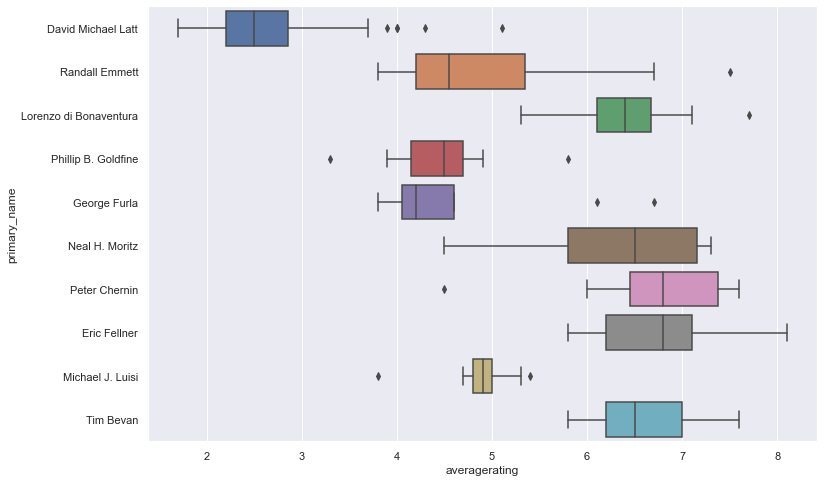

In [123]:
top_producer_info_pop('Action')